In [37]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

In [10]:
# d3 = await d3nx.create_d3nx_visualizer(
#     interactive=False,
#     node_dstyle=d3nx.node_style(size=5, fill="#FFFFFF", stroke="#494949"),
#     edge_dstyle=d3nx.edge_style(stroke_width=1.25),
#     event_delay=0,
#     canvas_size=(1000, 800)
# )

websocket server started...

networkx connected...

In [2]:
G = D3DiGraph(nx.read_gml("data/dart_stops.gml"))
# Unpack node pos from list to numpy array
nx.set_node_attributes(
    G,
    {node: np.array(pos) for node, pos in nx.get_node_attributes(G, "pos").items()},
    "pos",
)
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

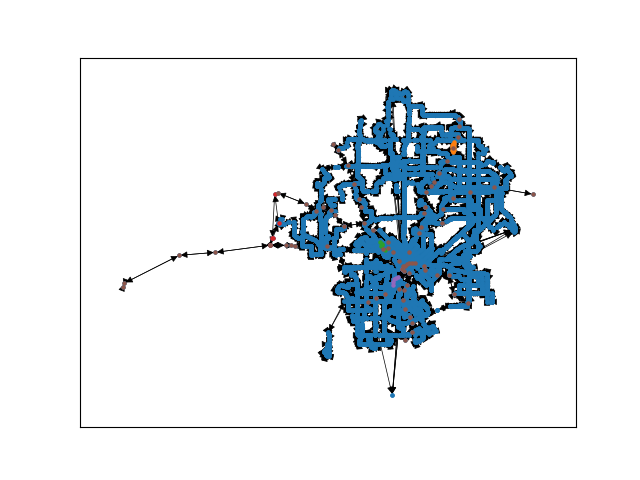

In [16]:
%matplotlib widget
pos = nx.get_node_attributes(G, "pos")

comps = list(nx.weakly_connected_components(G))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

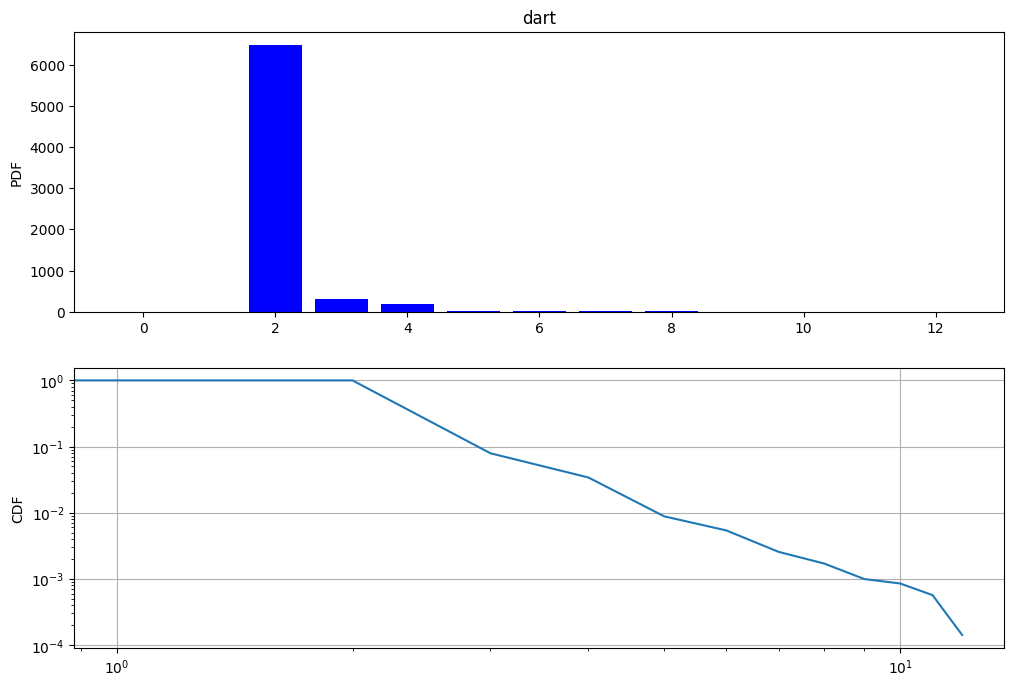

In [26]:
from powerlaw import calc_powerlaw_multi

calc_powerlaw_multi({"dart": G})
plt.show()

In [21]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
# import powerlaw
# import importlib
# importlib.reload(powerlaw)

<module 'powerlaw' from 'c:\\Users\\Andrew\\Code\\dcns-project\\powerlaw.py'>

In [27]:
G2 = G.subgraph(max(nx.strongly_connected_components(G), key=len))
nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight")

In [41]:
pos = pd.DataFrame(
    [(n, *p) for n, p in nx.get_node_attributes(G2, "pos").items()],
    columns=["name", "x", "y"],
).set_index("name")

In [85]:
def convolve_iter(arr: NDArray):
    """Iterate though an NDArray, yielding a flattened NDArray of the 3x3 surrounding cells."""
    for i, j in itertools.product(range(arr.shape[0]), range(arr.shape[1])):
        # get the indices of the cell's neighbors
        i1 = max(i - 1, 0)
        i2 = min(i + 2, arr.shape[0])
        j1 = max(j - 1, 0)
        j2 = min(j + 2, arr.shape[1])

        # sum the values of the cell and its neighbors
        yield arr[i1:i2, j1:j2].flatten()


def get_partition_size(node_positions: dict[str, NDArray], num_partitions: int):
    """Get the (x,y) size of each partition"""
    # determine the min and max x and y values
    x_min, y_min = np.min(list(node_positions.values()), axis=0)
    x_max, y_max = np.max(list(node_positions.values()), axis=0)

    # calculate the partition size in x and y directions
    return ((x_max - x_min) / num_partitions, (y_max - y_min) / num_partitions)


def partition_nodes(node_positions: dict[str, NDArray], num_partitions: int):
    """Partition a dictionary of positions into a grid"""
    # determine the min and max x and y values
    x_min, y_min = np.min(list(node_positions.values()), axis=0)
    x_max, y_max = np.max(list(node_positions.values()), axis=0)

    # calculate the partition size in x and y directions
    x_partition_size, y_partition_size = get_partition_size(
        node_positions, num_partitions
    )

    # create the partitions array
    partitions = np.empty((num_partitions, num_partitions), dtype=object)
    partitions[:] = [
        [set() for _ in range(partitions.shape[1])] for _ in range(partitions.shape[0])
    ]
    # partitions[:] = [[]*num_partitions]*num_partitions

    # assign each node to its corresponding partition
    for node_name, node_pos in node_positions.items():
        x_index = int((node_pos[0] - x_min) // x_partition_size) - 1
        y_index = int((node_pos[1] - y_min) // y_partition_size) - 1
        partitions[x_index, y_index].add(node_name)

    return partitions


def get_close_edges(pos: dict[str, NDArray], max_distance=0.001, num_partitions=50):
    partitions = partition_nodes(pos, num_partitions)
    close_edges = set()

    # Make sure our distance threshold is smaller than the size of the partitions
    x_partition_size, y_partition_size = get_partition_size(pos, num_partitions)
    if max_distance >= x_partition_size or max_distance >= y_partition_size:
        raise ValueError(
            f"Partition size {x_partition_size, y_partition_size} for {num_partitions} "
            f"partitions is smaller than max_distance {max_distance}"
        )

    for cell in tqdm(convolve_iter(partitions), total=num_partitions**2, desc="Cell"):
        nodes = set.union(*cell)
        # total_combinations = len(nodes) * (len(nodes)-1)

        close_edges.update(
            (u, v)
            for u, v in itertools.combinations(nodes, 2)
            # ), total=total_combinations, desc="Nodes in cell")
            if la.norm(pos[u] - pos[v]) < max_distance
        )
    return close_edges


e = get_close_edges(nx.get_node_attributes(G2, "pos"), 0.0005, 50)
print(len(e))

Cell:   0%|          | 0/2500 [00:00<?, ?it/s]

2895


In [81]:
print(e)

[('31724', '31717'), ('31724', '31717'), ('31724', '31717'), ('18923', '18879'), ('30894', '30879'), ('23466', '20139'), ('18923', '18879'), ('30878', '30895'), ('30894', '30879'), ('30881', '30892'), ('30882', '30891'), ('23466', '20139'), ('18923', '18879'), ('30878', '30895'), ('33746', '33747'), ('30894', '30879'), ('30881', '30892'), ('30882', '30891'), ('23466', '20139'), ('30878', '30895'), ('33746', '33747'), ('31717', '31724'), ('30881', '30892'), ('30882', '30891'), ('33746', '33747'), ('31717', '31724'), ('31724', '31717'), ('18915', '20142'), ('18915', '20142'), ('22178', '22177'), ('22104', '18876'), ('18923', '18879'), ('18925', '18877'), ('32137', '22176'), ('30894', '30879'), ('18915', '20142'), ('22178', '22177'), ('23466', '20139'), ('22104', '18876'), ('18923', '18879'), ('30878', '30895'), ('18925', '18877'), ('32137', '22176'), ('30894', '30879'), ('30882', '30891'), ('22178', '22177'), ('23466', '20139'), ('22104', '18876'), ('18923', '18879'), ('30878', '30895'),

In [ ]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]